<a href="https://colab.research.google.com/github/Salmaabidah/Extended-Kalman-Filter/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch, numpy as np

# Kalau saya sukanya cek versi dan apakah PyTorch (atau tensorflow) sudah dapat mengakses GPU atau belum
print("Using Numpy and Pytorch versions = {}, {}".format(np.__version__, torch.__version__))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device, end=', ')
if device.type == 'cuda': #Additional Info when using cuda
    print(torch.cuda.get_device_name(0))
    print('Currently Memory Allocated, Cached =', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB, ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using Numpy and Pytorch versions = 1.22.4, 2.0.1+cu118
Using device: cpu, 

In [2]:
import warnings; warnings.simplefilter('ignore')

try:
    import google.colab; IN_COLAB = True
    print("Installing the required modules")
    !pip install dysts
    !pip install darts
except:
    IN_COLAB = False
    print("Running the code locally, please make sure all the python module versions agree with colab environment and all data/assets downloaded")

Installing the required modules
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 MB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 53.9 MB/s eta 0:00:00
     

In [3]:
from dysts.datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import darts
from darts import TimeSeries
from darts.metrics import smape
from darts.metrics import mape


# Load Data untuk ekf



In [4]:
Datasets = load_dataset(subsets="train").names.tolist()
print("All Available ({}) Datasets:\n\n{}".format(len(Datasets), Datasets))

All Available (131) Datasets:

['Aizawa', 'AnishchenkoAstakhov', 'Arneodo', 'ArnoldBeltramiChildress', 'ArnoldWeb', 'BeerRNN', 'BelousovZhabotinsky', 'BickleyJet', 'Blasius', 'BlinkingRotlet', 'BlinkingVortex', 'Bouali', 'Bouali2', 'BurkeShaw', 'CaTwoPlus', 'CaTwoPlusQuasiperiodic', 'CellCycle', 'CellularNeuralNetwork', 'Chen', 'ChenLee', 'Chua', 'CircadianRhythm', 'CoevolvingPredatorPrey', 'Colpitts', 'Coullet', 'Dadras', 'DequanLi', 'DoubleGyre', 'DoublePendulum', 'Duffing', 'ExcitableCell', 'Finance', 'FluidTrampoline', 'ForcedBrusselator', 'ForcedFitzHughNagumo', 'ForcedVanDerPol', 'GenesioTesi', 'GuckenheimerHolmes', 'Hadley', 'Halvorsen', 'HastingsPowell', 'HenonHeiles', 'HindmarshRose', 'Hopfield', 'HyperBao', 'HyperCai', 'HyperJha', 'HyperLorenz', 'HyperLu', 'HyperPang', 'HyperQi', 'HyperRossler', 'HyperWang', 'HyperXu', 'HyperYan', 'HyperYangChen', 'IkedaDelay', 'IsothermalChemical', 'ItikBanksTumor', 'JerkCircuit', 'KawczynskiStrizhak', 'Laser', 'LiuChen', 'Lorenz', 'Lorenz84

In [5]:
data = 'ItikBanksTumor'
train_ = load_dataset(subsets="train", data_format="pandas", univariate=False).loc[data]
test_ = load_dataset(subsets="test", data_format="pandas", univariate=False).loc[data]

In [6]:
df_ = pd.concat([train_, test_], axis=0).reset_index()
df_

,index,id,time,values_0,values_1,values_2,values_3,values_4,values_5,values_6,values_7,values_8,values_9
0,ItikBanksTumor,58.0,0.000000,0.062447,0.176740,-0.440915,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ItikBanksTumor,58.0,0.497815,0.117306,0.120023,-0.433010,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ItikBanksTumor,58.0,0.995630,0.176890,0.058623,-0.422386,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ItikBanksTumor,58.0,1.493445,0.241105,-0.007472,-0.408223,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ItikBanksTumor,58.0,1.991259,0.309627,-0.078163,-0.389482,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ItikBanksTumor,58.0,495.325771,-0.399641,0.725511,-0.549025,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,ItikBanksTumor,58.0,495.823586,-0.382185,0.704367,-0.549160,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,ItikBanksTumor,58.0,496.321401,-0.363304,0.681691,-0.549275,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,ItikBanksTumor,58.0,496.819216,-0.342759,0.657271,-0.549372,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA

In [7]:
df = df_[['values_0','values_1','values_2']]
df.columns= ['sel tumor','sel inang','sel imun']

In [9]:
# Simpan data di drive 
#from google.colab import drive
#drive.mount('/content/drive')
#path = '/content/drive/My Drive/Code + Data Skripsi/Data.csv'
#with open(path, 'w', encoding = 'utf-8-sig') as f:
#  df.to_csv(f)

In [10]:
df.corr()

,sel tumor,sel inang,sel imun
sel tumor,1.000000,-0.630137,-0.004477
sel inang,-0.630137,1.000000,-0.648025
sel imun,-0.004477,-0.648025,1.000000


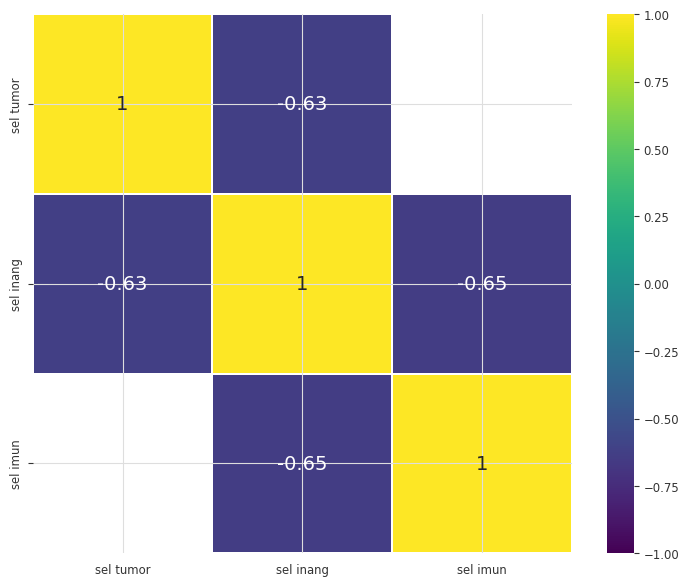

In [11]:
# HeatMap untuk menyelidiki korelasi
import seaborn as sns
corr2 = df.corr() # We already examined SalePrice correlations
plt.figure(figsize=(9, 7))
sns.heatmap(corr2[(corr2 >= 0.5) | (corr2 <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 14}, square=True);

In [12]:
!pip install nolds
import nolds

def eda(df):
  #series = pd.concat([series_train, series_test], ignore_index=True)
  entropy = nolds.sampen(df)
  largest_lyap = nolds.lyap_r(df, emb_dim=3)

  return entropy, largest_lyap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
entropy_x, largest_lyap_x= eda(df['sel tumor'][:1000])
entropy_y, largest_lyap_y= eda(df['sel inang'][:1000])
entropy_z, largest_lyap_z= eda(df['sel imun'][:1000])

print(f"Entropy untuk time series sel tumor adalah {entropy_x}, Entropy untuk time series sel inang adalah {entropy_y}, dan Entropy untuk time series sel imun efektor adalah {entropy_z}")
print(f"Lyapunov exponent terbesar dari sel tumor adalah {largest_lyap_x}, Lyapunov exponent terbesar dari sel inang adalah {largest_lyap_y}, dan Lyapunov exponent terbesar dari sel imun efektor adalah {largest_lyap_z}")


Entropy untuk time series sel tumor adalah 0.08273613447152149, Entropy untuk time series sel inang adalah 0.1373855120195727, dan Entropy untuk time series sel imun efektor adalah 0.057741459607187816
Lyapunov exponent terbesar dari sel tumor adalah 0.05418281680659245, Lyapunov exponent terbesar dari sel inang adalah 0.04324670770114525, dan Lyapunov exponent terbesar dari sel imun efektor adalah 0.06793343088680631


In [14]:
a = max((df['sel tumor']))
b = max((df['sel inang']))
c = max((df['sel imun']))
d = min((df['sel tumor']))
e = min((df['sel inang']))
f = min((df['sel imun']))
df[(df['sel tumor'] == a) | (df['sel tumor'] == d) | (df['sel inang'] == b) | (df['sel inang'] == e) | (df['sel imun'] == c) | (df['sel imun'] == f)]

,sel tumor,sel inang,sel imun
189,-0.711343,1.126696,-0.548915
236,-0.110114,0.416810,-0.580440
260,4.303777,-2.187324,-0.350449
265,1.012215,-2.237794,3.961338
266,0.144556,-2.235104,4.783165
272,-0.736117,-2.145332,1.713358


# Koefisien hasil linearisasi

In [15]:
#nilai awal  
t = 0.01
h = 0.01
e = 0.01


t2_ = t - (t**2) - (t*h) - (2.5*t*e)  # f
t3 = 1 - (2*t) - h - (2.5*e)        # turunan t
t3_ = t3*(-t)                  # f(t)'*(t-t0)
t4 = -t                        # turunan h
t4_ = t4*(-h)                  # f(h)'*(h-h0)
t5 = - 2.5*t                   # turunan e
t5_ = t5*(-e)                  # f(e)'*(e-e0)
t_total = t2_ + t3_ + t4_ + t4_

t3, t4, t5, t_total

(0.945, -0.01, -0.025, 0.0003000000000000011)

In [16]:
h2_ = 0.6*h - 0.6*h**2 - 1.5*t*h    #f
h3 = -1.5*h                         #turunan t 
h3_ = h3*(-t)                       #f(t)'*(t-t0)
h4 = 0.6 - 0.6*2*h - 1.5*t          #turunan h
h4_ = h4*(-h)                       #f(h)'*(h-h0)
h_total = h2_ + h3_ + h4_

h3, h4, h_total

(-0.015, 0.573, 0.00021000000000000012)

In [17]:
e2_ = ((4.5*t*e)/(t+1)) - 0.2*t*e - 0.5*e   #f
e3 = ((4.5*e)/(t+1)**2) - 0.2*e             #turunan t
e3_ = e3*(-t)                               #f(t)'*(t-t0)
e4 = ((4.5*t)/(t+1)) - 0.2*t - 0.5          #turunan e 
e4_ = e4*(-h)                               #f(h)'*(h-h0)
e_total = e2_ + e3_ + e4_

e3, e4, e_total

(0.042113322223311433, -0.45744554455445546, -0.0004211332222331136)

# EKF 

In [18]:
df2 = df_[['values_0', 'values_1', 'values_2']]
df3 = df2[:1890].reset_index()
df3.drop('index', axis=1, inplace=True)
ndf_train = df3.to_numpy()

In [19]:
n = len(ndf_train)-1
wt = np.random.normal(0.05, 0.001, n)
wh = np.random.normal(0.06, 0.001, n)
we = np.random.normal(0.8, 0.01, n)
w = np.stack((wt,wh, we), axis=1)

vt = np.random.normal(0.01, 0.001, n)
vh = np.random.normal(0.01, 0.001, n)
ve = np.random.normal(0.01, 0.001, n)
v = np.stack((vt,vh,ve), axis=1)

A = np.array([[t3, t4, t5],
              [h3, h4 , 0],
              [e3, 0, e4]])

koef = np.array([t_total, h_total, e_total])

Q = np.array([[0.05, 0, 0],
              [0, 0.07, 0],
              [0, 0, 0.8]]) # given Q matrix

H = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]]) # given H matrix

R = np.array([[0.01, 0, 0],
              [0, 0.01, 0],
              [0, 0, 0.01]]) # given R matrix

x = [np.array([0.062447,	0.176740,	-0.440915])]
p = [np.array([[0.05, 0, 0],
              [0, 0.07, 0],
              [0, 0, 0.8]])]
EKF = [np.array([0.062447,	0.176740,	-0.440915])]
res = []

for i in range(n):
    #prediksi
    prediksi = A @ EKF[-1] + koef + w[i]
    x.append(prediksi)

    #kovarian error
    kov_er = (A + koef) @ p[-1] @ A.T + Q 

    #kalman gain
    res_kov = np.linalg.inv((H @ kov_er @ H.T) + R)
    kalman_gain = kov_er @ H.T @ (res_kov)
    

    #koreksi
    res_mean = ndf_train[i] - (H @ prediksi + v[i])
    koreksi = prediksi + kalman_gain @ res_mean
    EKF.append(koreksi)

    #update kovarian
    up_kov = (H - kalman_gain @ H) @ kov_er
    p.append(up_kov)
    up_kov_norm = np.linalg.norm(up_kov)
    res.append(up_kov_norm)



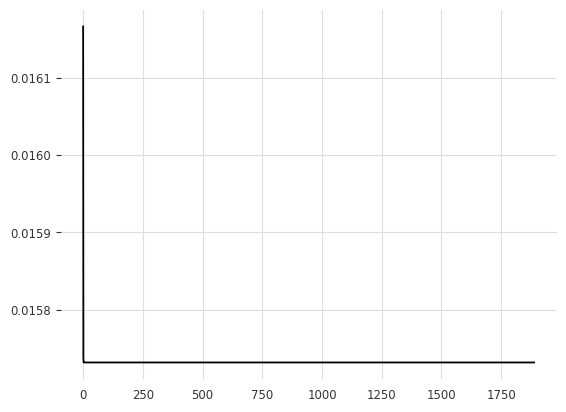

In [20]:
res_ = np.array(res)
plt.plot(res_[:])

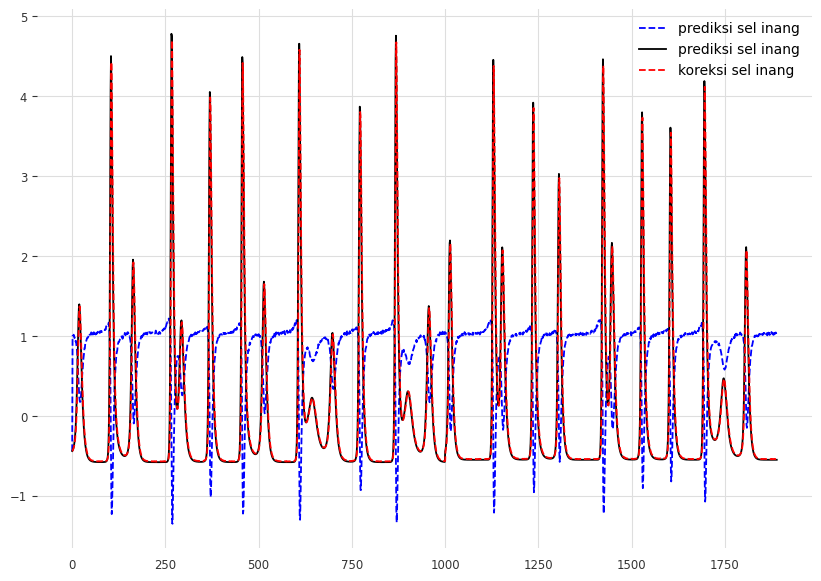

In [22]:
prediksi_ = np.array(x) 
EKF = np.array(EKF) 
ndf_train = np.array(ndf_train)
plt.figure(figsize=[10,7])
plt.plot(prediksi_[:,2], 'b--', label = 'prediksi sel inang')
plt.plot(ndf_train[:,2], label = 'prediksi sel inang')
plt.plot(EKF[:,2], 'r--',label='koreksi sel inang')
plt.legend()

In [23]:
data_train = TimeSeries.from_values(ndf_train)
EKF_train = TimeSeries.from_values(EKF)
prediksi_train = TimeSeries.from_values(prediksi_)

In [24]:
smape_train = darts.metrics.smape(data_train, EKF_train)
rmse_train = darts.metrics.rmse(data_train, EKF_train)
print("Pada data test RMSE={}, sMAPE={}".format(rmse_train, smape_train), flush=True)

Pada data test RMSE=0.16655776857764626, sMAPE=21.46082886585663


# Prediksi data dengan EKF

**Dilakukkan tanpa menggunakan tahapan koreksi**

In [25]:
df2 = df_[['values_0', 'values_1', 'values_2']]
df3 = df2[1890:1896].reset_index()
df3.drop('index', axis=1, inplace=True)
ndf_test = df3.to_numpy()

In [26]:
xt = [np.array([-0.048973,0.333618, -0.550526])]
pt = [np.array([[0.5, 0, 0],
              [0, 0.5, 0],
              [0, 0, 0.5]])]
EKF_test = []

n = len(ndf_test)-1
wt = np.random.normal(0.05, 0.001, n)
wh = np.random.normal(0.04, 0.001, n)
we = np.random.normal(0.8, 0.01, n)
w = np.stack((wt, wh, we), axis=1)

vt = np.random.normal(0.01, 0.001, n)
vh = np.random.normal(0.01, 0.001, n)
ve = np.random.normal(0.01, 0.001, n)
v = np.stack((vt,vh,ve), axis=1)


for i in range(n):
    #prediksi
    prediksi = A @ xt[-1] + koef + w[i]
    xt.append(prediksi)

    #kovarian error
    kov_er = A @ pt[-1] @ A.T + Q
    pt.append(kov_er)

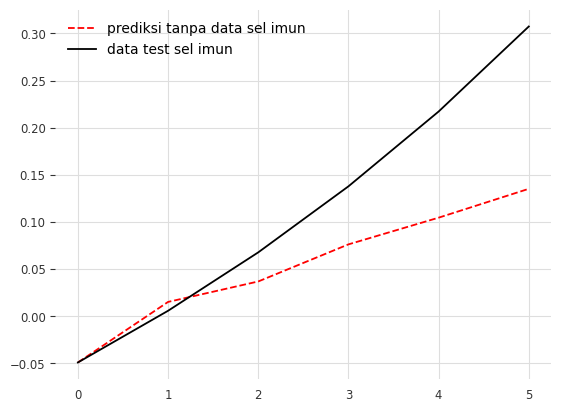

In [31]:
prediksi_data_test = np.array(xt) 
plt.plot(prediksi_data_test[:,0], 'r--', label = 'prediksi tanpa data sel imun')
plt.plot(ndf_test[:,0], '-', label = 'data test sel imun')
plt.legend()

In [28]:
data_test = TimeSeries.from_values(ndf_test)
prediksi_test = TimeSeries.from_values(prediksi_data_test)

In [29]:
smape_test = darts.metrics.smape(data_test, prediksi_test)
rmse_test = darts.metrics.rmse(data_test, prediksi_test)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_test, smape_test), flush=True)

Pada data test RMSE=0.4098180952800831, sMAPE=91.60979504130562 
